# Libraies

In [179]:
# Data Handling
import numpy as np
import pandas as pd

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.metrics import ConfusionMatrixDisplay

# Models
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    classification_report, confusion_matrix,
    precision_recall_curve, auc, classification_report, roc_auc_score,
    precision_recall_fscore_support, average_precision_score)
from sklearn.preprocessing import FunctionTransformer

from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler

# Pipeline
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
import itertools

# Imbalance Handling
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTEENN,SMOTETomek
from sklearn.utils.class_weight import compute_class_weight

# Notebook functionality
from IPython.display import clear_output, display
import time 

# Dimensionnality reduction
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import make_scorer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.feature_selection import VarianceThreshold

# Load data

## Original
- Original target labeling is No Defect = -1, Defect = 1
- Remapped to No Defect = 0, Defect = 1

In [2]:
# Define column names (since UCI does not provide them)
feature_columns = [f"feature_{i}" for i in range(590)]  # 590 features

# Load features
secom_features = pd.read_csv(
    "../secom/secom.data", 
    sep=" ", 
    names=feature_columns, 
    header=None, 
    engine='python'
)

# Load labels
secom_labels = pd.read_csv(
    "../secom/secom_labels.data", 
    sep=" ", 
    header=None, 
    usecols=[0]  # Only the first column contains the label
)

# Rename label column
secom_labels.columns = ["Label"]

# Convert labels: -1 (pass) -> 0, 1 (fail) -> 0
secom_labels["Label"] = secom_labels["Label"].replace({-1: 0, 1: 1})

# Combine features and labels into a single DataFrame
secom_data = pd.concat([secom_features, secom_labels], axis=1)

secom_data.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_581,feature_582,feature_583,feature_584,feature_585,feature_586,feature_587,feature_588,feature_589,Label
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,0
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0


### Missing values
- Columns missing more than 10% of values were dropped
    - Amt of features reduced from 590 to 538 (-52 features)
- 2 imputation methods were tried: Median, MICE
    - MICE reesulted in the better benchmark using LR, RF, & XGB

## MICE dataset

In [3]:
secom_MICE = pd.read_csv('../secom/secom_MICE_imputed')

secom_MICE.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_577,feature_582,feature_583,feature_584,feature_585,feature_586,feature_587,feature_588,feature_589,Label
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,14.9509,0.5005,0.0118,0.0035,2.3630,0.021247,0.015558,0.005138,100.525349,0
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,10.9003,0.5019,0.0223,0.0055,4.4447,0.009600,0.020100,0.006000,208.204500,0
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,9.2721,0.4958,0.0157,0.0039,3.1745,0.058400,0.048400,0.014800,82.860200,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,8.5831,0.4990,0.0103,0.0025,2.0544,0.020200,0.014900,0.004400,73.843200,0
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,10.9698,0.4800,0.4766,0.1045,99.3032,0.020200,0.014900,0.004400,73.843200,0


# Drop Low Variance features

## Variance = 0.0 (secom_filtered)

In [6]:
# Drop columns where variance == 0
secom_filtered = secom_MICE.loc[:, secom_MICE.var() != 0]

### Shape change

In [9]:
print("Total Num Features before = ", secom_MICE.shape[1])
print("Total Num Features after = ", secom_filtered.shape[1])
print("\nChange = ", secom_filtered.shape[1] - secom_MICE.shape[1])

Total Num Features before =  539
Total Num Features after =  423

Change =  -116


In [10]:
print(secom_filtered.loc[:, secom_filtered.var() <= 0.01].shape)
print(secom_filtered.loc[:, secom_filtered.var() <= 0.05].shape)

(1567, 144)
(1567, 172)


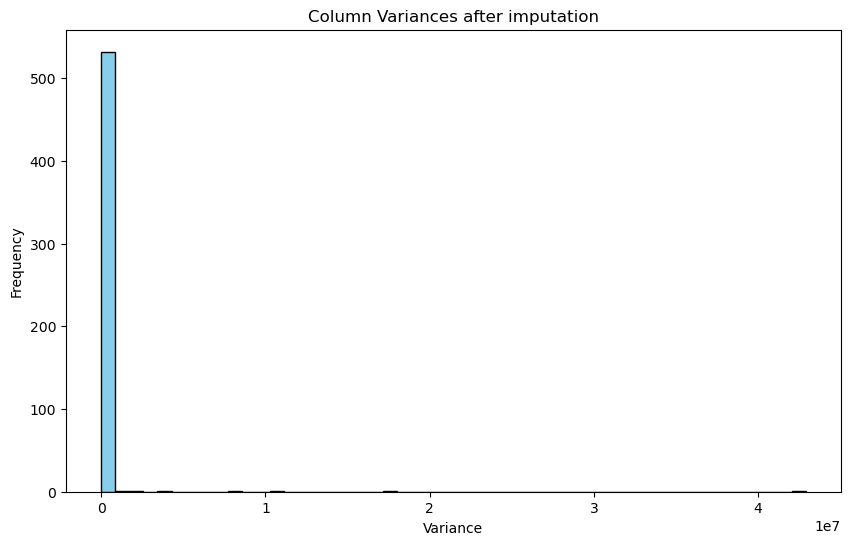

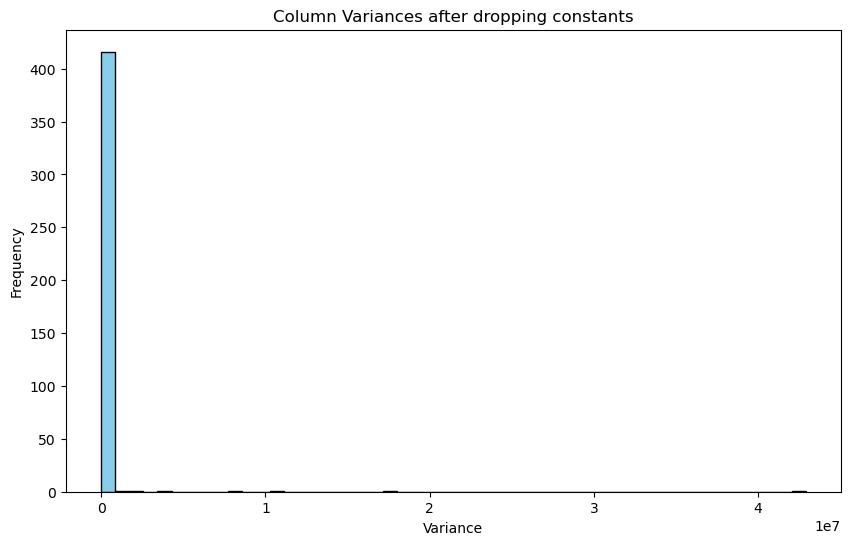

In [12]:
# Plot a histogram of the variances
variances_MICE = secom_MICE.var()

plt.figure(figsize=(10, 6))
plt.hist(variances_MICE, bins=50, color='skyblue', edgecolor='black')
plt.title('Column Variances after imputation')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.show()

variances_filtered = secom_filtered.var()

plt.figure(figsize=(10, 6))
plt.hist(variances_filtered, bins=50, color='skyblue', edgecolor='black')
plt.title('Column Variances after dropping constants')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.show()

## Variance > 0.05 (secom_filtered02)

In [57]:
secom_filtered02 = secom_filtered.loc[:, secom_filtered.var() > 0.05]

### Shape Change

In [58]:
print("Total Num Features before = ", secom_filtered.shape[1])
print("Total Num Features after = ", secom_filtered02.shape[1])
print("\nChange = ", secom_filtered02.shape[1] - secom_filtered.shape[1])

Total Num Features before =  423
Total Num Features after =  251

Change =  -172


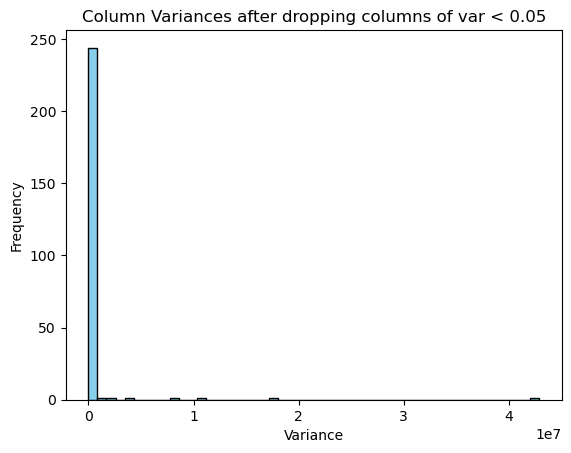

In [25]:
variances_filtered02 = secom_filtered02.var()

#plt.figure(figsize=(10, 6))
plt.hist(variances_filtered02, bins=50, color='skyblue', edgecolor='black')
plt.title('Column Variances after dropping columns of var < 0.05')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.show()

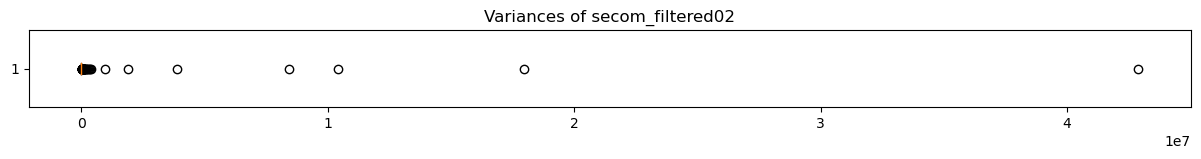

In [32]:
plt.figure(figsize=(15,1))
plt.boxplot(variances_filtered02, vert=False)
plt.title("Variances of secom_filtered02")
plt.show()

## Investigate variance spread

In [34]:
#print("Min = ")
variances_filtered02.describe()

count    2.510000e+02
mean     3.590959e+05
std      3.052287e+06
min      5.032405e-02
25%      4.616148e+00
50%      5.049557e+01
75%      1.170852e+03
max      4.289458e+07
dtype: float64

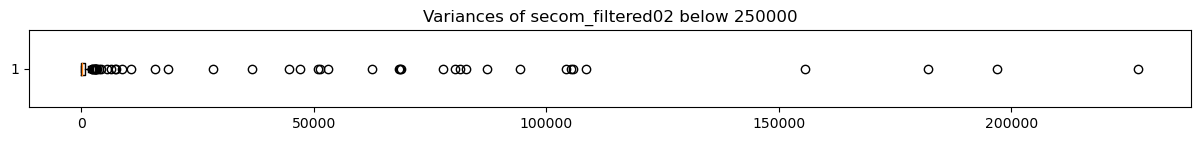

In [40]:
a = 10000000
b = 2000000
c = 250000

threshold = c

filtered_variances = variances_filtered02[variances_filtered02 < threshold]

plt.figure(figsize=(15,1))
plt.boxplot(filtered_variances, vert=False)
plt.title(f"Variances of secom_filtered02 below {threshold}")
plt.show()

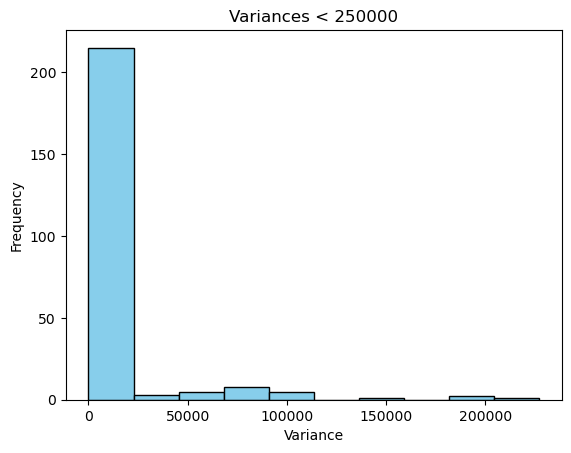

In [41]:
plt.hist(variances_filtered02[variances_filtered02 < c], color='skyblue', edgecolor='black')
plt.title('Variances < 250000')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.show()

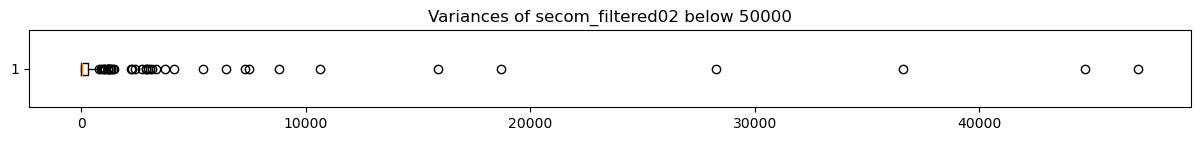

In [44]:
plt.figure(figsize=(15,1))
plt.boxplot(variances_filtered02[variances_filtered02 < 50000], vert=False)
plt.title("Variances of secom_filtered02 below 50000")
plt.show()

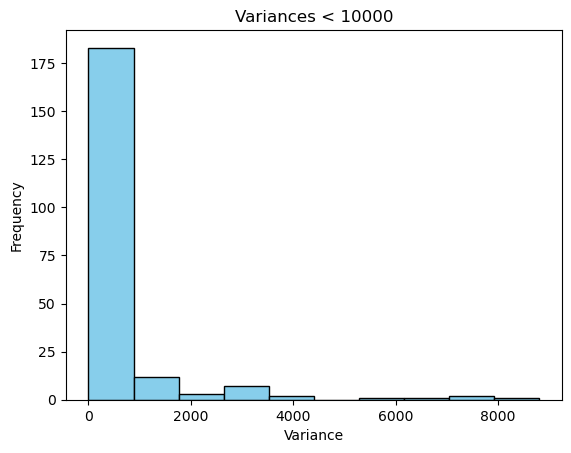

In [45]:
plt.hist(variances_filtered02[variances_filtered02 < 10000], color='skyblue', edgecolor='black')
plt.title('Variances < 10000')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.show()

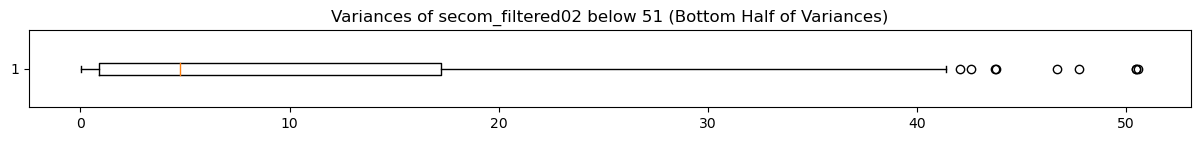

In [52]:
plt.figure(figsize=(15,1))
plt.boxplot(variances_filtered02[variances_filtered02 < 51], vert=False)
plt.title("Variances of secom_filtered02 below 51 (Bottom Half of Variances)")
plt.show()

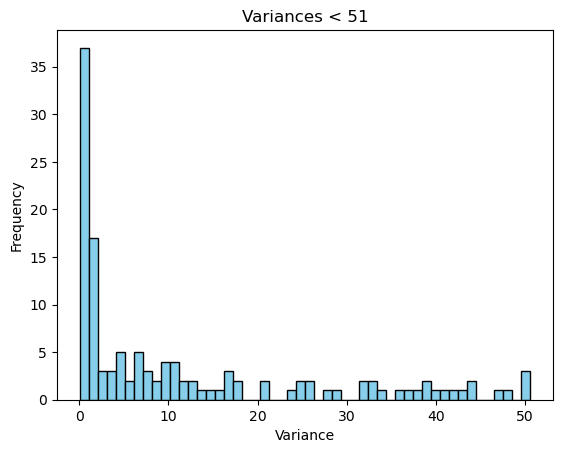

In [50]:
plt.hist(variances_filtered02[variances_filtered02 < 51], bins=50, color='skyblue', edgecolor='black')
plt.title('Variances < 51')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.show()

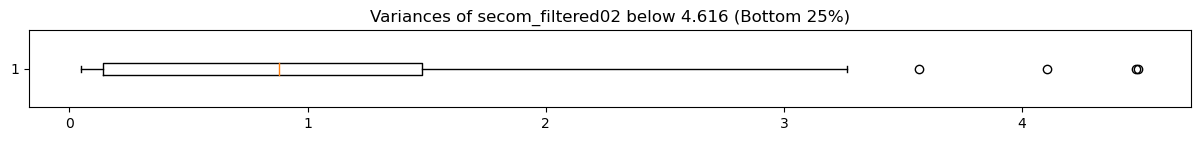

In [53]:
plt.figure(figsize=(15,1))
plt.boxplot(variances_filtered02[variances_filtered02 < 4.616], vert=False)
plt.title("Variances of secom_filtered02 below 4.616 (Bottom 25%)")
plt.show()

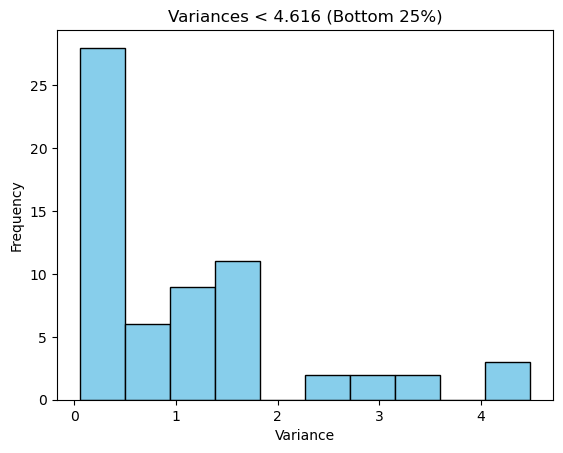

In [54]:
plt.hist(variances_filtered02[variances_filtered02 < 4.616], color='skyblue', edgecolor='black')
plt.title('Variances < 4.616 (Bottom 25%)')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.show()

## Variance > 4.616 (secom_filtered03)

In [153]:
secom_filtered03 = secom_filtered.loc[:, secom_filtered.var() > 4.616].copy()
secom_filtered03['Label'] = secom_filtered['Label']


### Shape Change

In [60]:
print("Total Num Features before = ", secom_filtered02.shape[1])
print("Total Num Features after = ", secom_filtered03.shape[1])
print("\nChange = ", secom_filtered03.shape[1] - secom_filtered02.shape[1])

Total Num Features before =  251
Total Num Features after =  188

Change =  -63


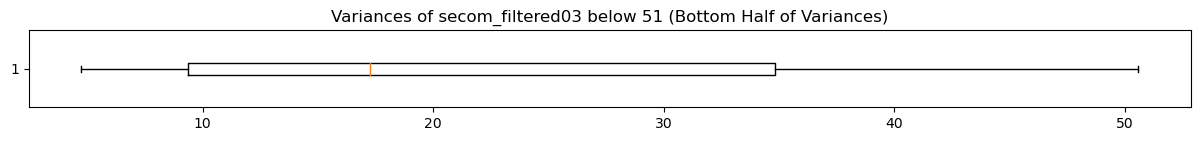

In [62]:
variances_filtered03 = secom_filtered03.var()

plt.figure(figsize=(15,1))
plt.boxplot(variances_filtered03[variances_filtered03 < 51], vert=False)
plt.title("Variances of secom_filtered03 below 51 (Bottom Half of Variances)")
plt.show()

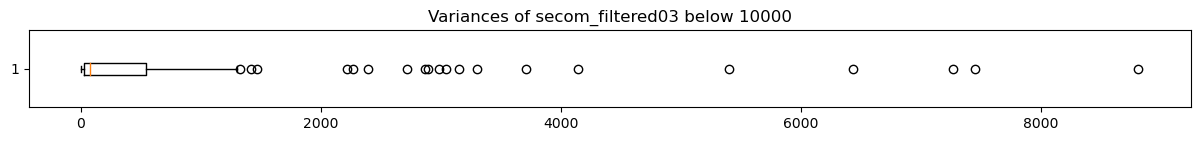

In [64]:
plt.figure(figsize=(15,1))
plt.boxplot(variances_filtered03[variances_filtered03 < 10000], vert=False)
plt.title("Variances of secom_filtered03 below 10000")
plt.show()

# Choose df

### Eval df test

In [130]:
'''
def plot_confusion_matrix(cm, model_name='[model]', sampler_name='[sampler]', labels=['No Defect: 0', 'Defect: 1']):
    title = f"{model_name} on {sampler_name}"
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels, yticklabels=labels,
                annot_kws={"size": 18})
    plt.title(title, fontsize=20)
    plt.xlabel('Predicted Label', fontsize=16)
    plt.ylabel('True Label', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()
'''
'''
def eval_df(df, model, k=5):
    # define feature matrix
    X = df.drop(columns='Label')
    # define target (no-defect = 0, defect = 1)
    y = df['Label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Generate the classification report
    report = classification_report(y_test, y_pred)
    print(report)

'''

def eval_df(model, df, model_name="[No model name passed]", df_name="[No df name passed]",  labels=labels):
    """
    Trains and evaluates a model.

    Args:
        model: scikit-learn compatible model
        X_train (DataFrame or array): Training features
        y_train (Series or array): Training labels
        X_val (DataFrame or array): Validation features
        y_val (Series or array): Validation labels
        labels (list): Optional list of label names for plotting

    Returns:
        report_dict (dict): Classification report as a dictionary
    """

    # define feature matrix
    X = df.drop(columns='Label')
    # define target (no-defect = 0, defect = 1)
    y = df['Label']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Predict on validation set
    y_pred = model.predict(X_val)

    # Generate classification report
    report_dict = classification_report(y_val, y_pred, output_dict=True)

    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    fig, ax = plt.subplots(figsize=(6, 5))
    #disp.plot(ax=ax, cmap='Blues', values_format='d')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels, yticklabels=labels,
                annot_kws={"size": 18})
    plt.title(f"{model_name} trained on {df_name}")
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('True', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

    return cm




Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.72      0.80       290
           1       0.06      0.21      0.09        24

    accuracy                           0.68       314
   macro avg       0.49      0.46      0.45       314
weighted avg       0.85      0.68      0.75       314



/home/reese_quinto/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


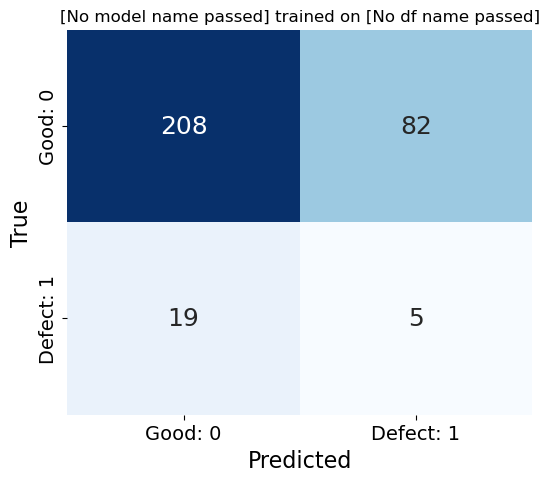

array([[208,  82],
       [ 19,   5]])

In [131]:
model_lr = LogisticRegression(class_weight='balanced', random_state=42)
model_rf = RandomForestClassifier(class_weight="balanced", random_state=42)

labels = ['Good: 0', 'Defect: 1']

eval_df(df=secom_filtered02, model=model_lr, labels=labels)

## Function: Scale Data (scale_data)

In [164]:
scaler = StandardScaler()

def scale_data(df, scaler=StandardScaler(), target_col='Label'):
    '''
    Applies a scaler of choice whith default as Standard Scaler
    Args:
        df : DataFrame to be scaled
        scaler : scaler of choice
    Returns:
        pd.DataFrame : scaled DataFrame
    '''
    X = df.drop(columns=target_col)
    y = df[target_col]

    X_scaled = scaler.fit_transform(X)
    df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    df_scaled[target_col] = y.values  # add target back
    return df_scaled

## Function: Apply Resampling for balance (resample)

In [168]:
def resample(df, target_col='Label', resampler=BorderlineSMOTE(random_state=42)):
    """
    Applies BorderlineSMOTE to a DataFrame.
    Args:
        df (pd.DataFrame): The input DataFrame.
        target_col (str): The name of the target column.
        resampler: Any imbalanced-learn resampler (e.g., BorderlineSMOTE instance).
    Returns:
        pd.DataFrame: Resampled DataFrame with BorderlineSMOTE applied.
    """
    # Separate features and target
    X = df.drop(columns=target_col)
    y = df[target_col]
    
    # Apply resampler
    X_resampled, y_resampled = resampler.fit_resample(X, y)

    # Reconstruct DataFrame with pd.concat to avoid fragmentation
    df_resampled = pd.concat(
        [pd.DataFrame(X_resampled, columns=X.columns), 
         pd.Series(y_resampled, name=target_col)],
        axis=1
    )

    return df_resampled


## Function: Apply LDA (apply_LDA)

In [169]:
def apply_lda(df, target_col='Label', n_components=None):
    """
    Applies Linear Discriminant Analysis (LDA) to reduce dimensionality.

    Args:
        df (pd.DataFrame): The input dataframe including target.
        target_col (str): Name of the target column.
        n_components (int or None): Number of LDA components to keep. 
                                    If None, use max possible: min(n_classes - 1, n_features)
    Returns:
        pd.DataFrame: Transformed DataFrame with LDA components + target column.
    """
    
    # Separate features, X, and target, y
    X = df.drop(columns=target_col)
    y = df[target_col]

    # apply LDA
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    X_lda = lda.fit_transform(X, y)

    # Reconstruct DataFrame & apply column names
    col_names = [f"LDA_{i+1}" for i in range(X_lda.shape[1])]
    df_lda = pd.DataFrame(X_lda, columns=col_names)
    df_lda[target_col] = y.values

    return df_lda

We have three separate data frames each having dropped columns with variance below a certain threshold. Var = 0, var < 0.05, and var < 4.616 (the last being the bottom 25% of column variance values). The dataframe names respectively are secom_filtered, secom_filtered02, and secom_filtered03. We want to know which one will result in the best trained logistic regression model (as shown to be the best performer from previous work). Remaining steps are to scale the data (we will use Standard Scaler), apply resampling to solve for imbalance (we will use BorderlineSMOTE for the same reason), and to apply LDA to further reduce dimentionality. The question concerning these three steps is the order in which they are applied to result in the best performing model. Each df will have each step applied in every permutation of order ( 3*3! = 18 ) for a total of 18 separate experiments
- Data Frames:
    - secom_filtered
    - secom_filtered02
    - secom_filtered03
- Functions
    - Scale Data: scale_data(df, scaler=StandardScaler(), target_col='Label')
    - Resample: resample(df, target_col='Label', resampler=BorderlineSMOTE(random_state=42))
    - LDA: apply_lda(df, target_col='Label', n_components=None)

## Apply Permutations

In [171]:
# Your original DataFrames
dfs = [secom_filtered, secom_filtered02, secom_filtered03]
df_names = ['Var > 0', 'Var > 0.05', 'Var > 4.616']

# Define function callables with names and fixed kwargs using lambdas
funcs_with_names = [
    (lambda df: scale_data(df, scaler=StandardScaler(), target_col='Label'), "Scale"),
    (lambda df: resample(df, target_col='Label', resampler=BorderlineSMOTE(random_state=42)), "Resample"),
    (lambda df: apply_lda(df, target_col='Label', n_components=None), "LDA")
]

# Generate all permutations of function applications
func_permutations = list(itertools.permutations(funcs_with_names))

# Results: list of (transformed_df, original_df_name, function_sequence_str)
results = []

for df, df_name in zip(dfs, df_names):
    for func_perm in func_permutations:
        new_df = df.copy()
        func_sequence = []

        for func, name in func_perm:
            new_df = func(new_df)  # call the function with df as argument
            func_sequence.append(name)

        sequence_str = "_".join(func_sequence)
        results.append((new_df, df_name, sequence_str))

        print(f"Applied {sequence_str} to {df_name}")

Applied Scale_Resample_LDA to Var > 0
Applied Scale_LDA_Resample to Var > 0
Applied Resample_Scale_LDA to Var > 0
Applied Resample_LDA_Scale to Var > 0
Applied LDA_Scale_Resample to Var > 0
Applied LDA_Resample_Scale to Var > 0
Applied Scale_Resample_LDA to Var > 0.05
Applied Scale_LDA_Resample to Var > 0.05
Applied Resample_Scale_LDA to Var > 0.05
Applied Resample_LDA_Scale to Var > 0.05
Applied LDA_Scale_Resample to Var > 0.05
Applied LDA_Resample_Scale to Var > 0.05
Applied Scale_Resample_LDA to Var > 4.616
Applied Scale_LDA_Resample to Var > 4.616
Applied Resample_Scale_LDA to Var > 4.616
Applied Resample_LDA_Scale to Var > 4.616
Applied LDA_Scale_Resample to Var > 4.616
Applied LDA_Resample_Scale to Var > 4.616


In [174]:
results[0][0]

,LDA_1,Label
0,-4.333546,0
1,-3.341312,0
2,2.466419,1
3,-1.827344,0
4,-1.519991,0
...,...,...
2921,2.041064,1
2922,0.563248,1
2923,2.789397,1
2924,2.049609,1


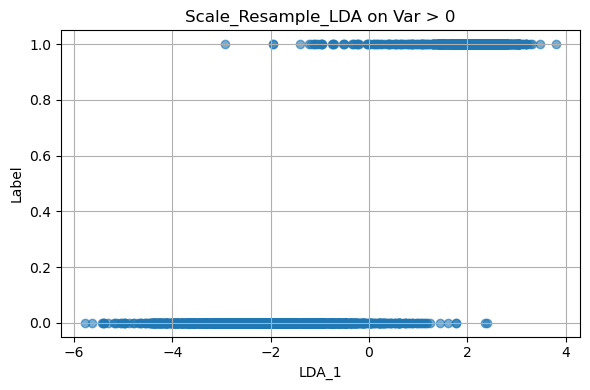

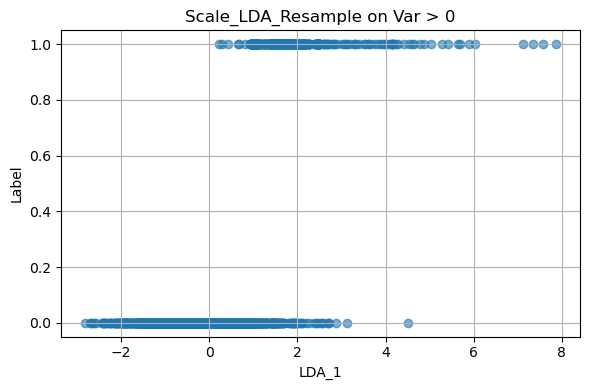

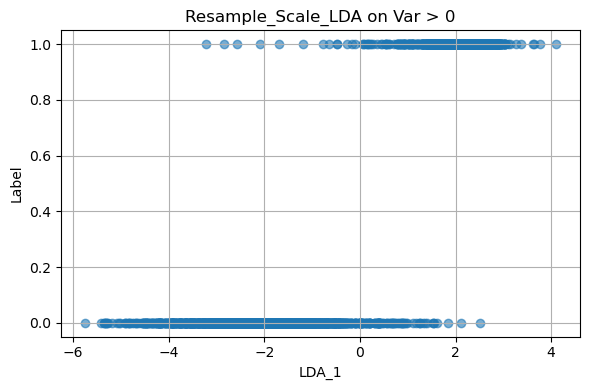

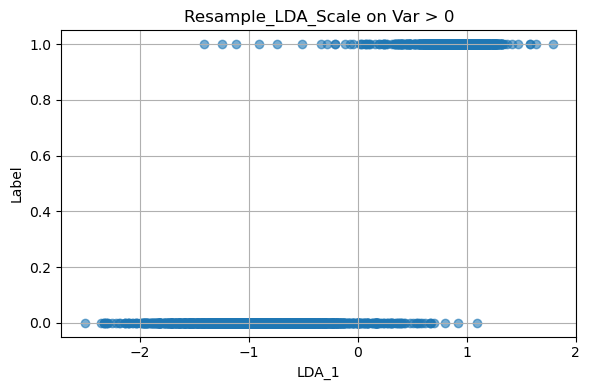

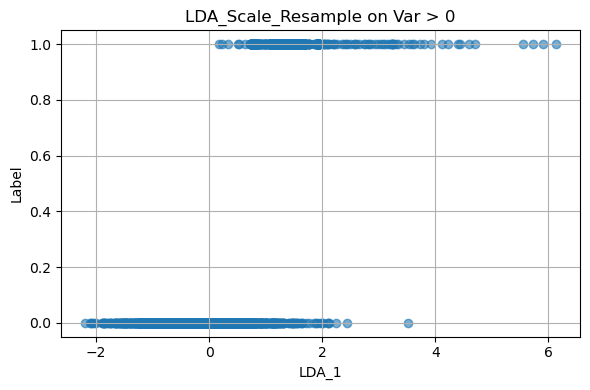

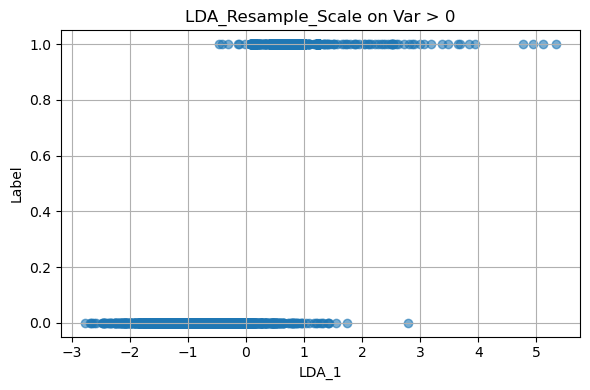

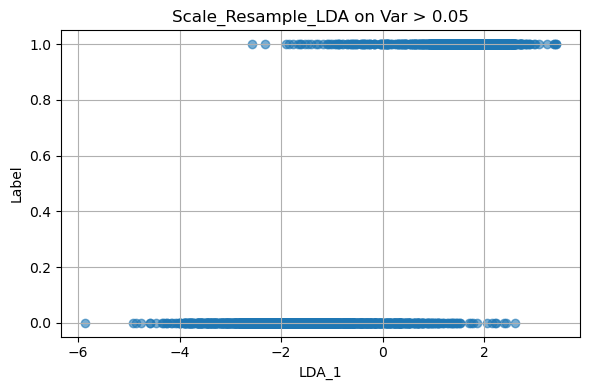

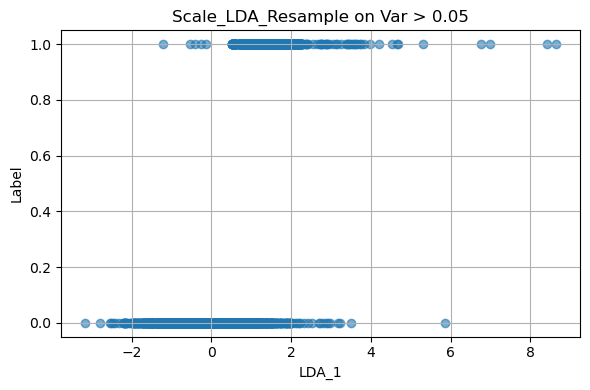

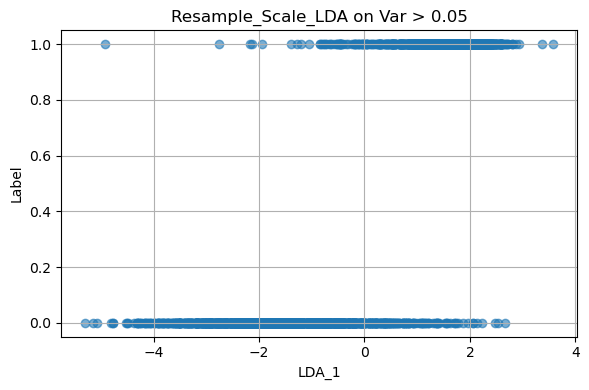

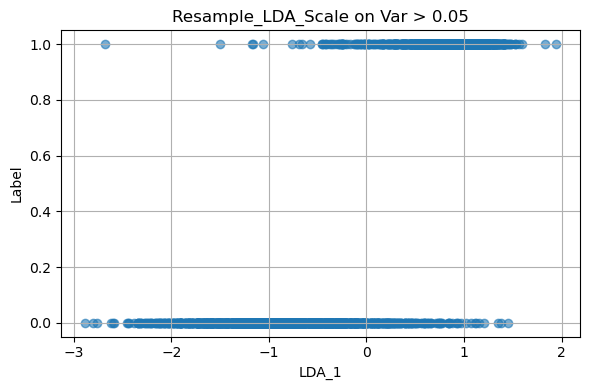

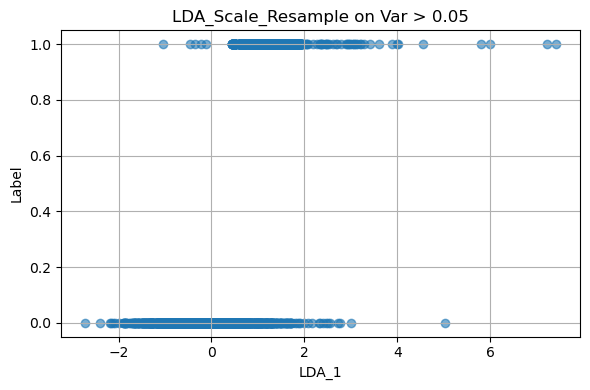

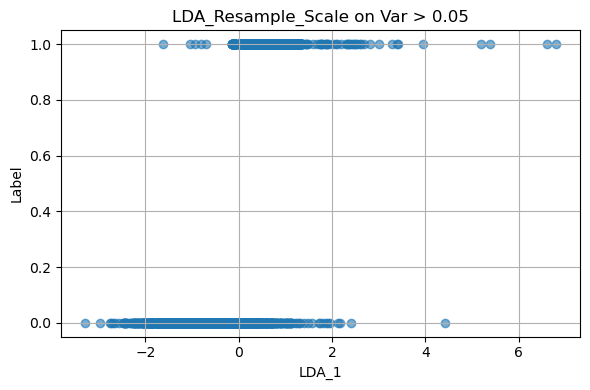

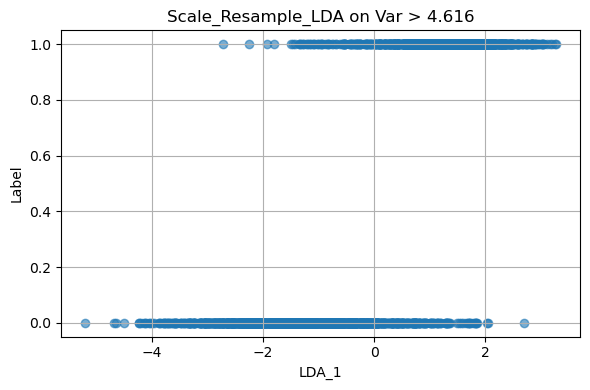

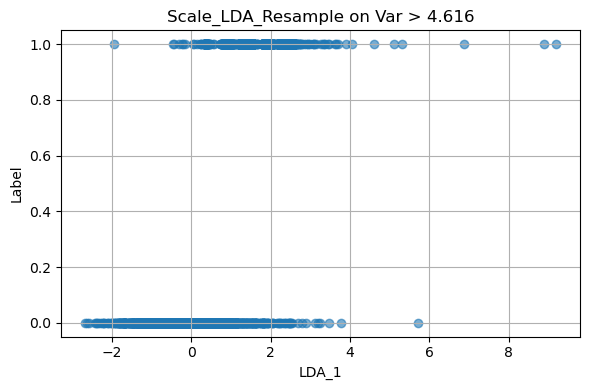

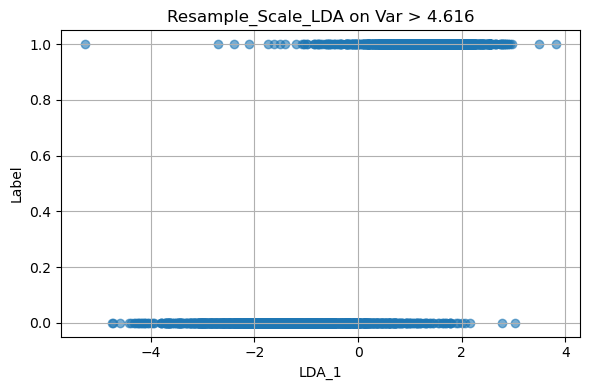

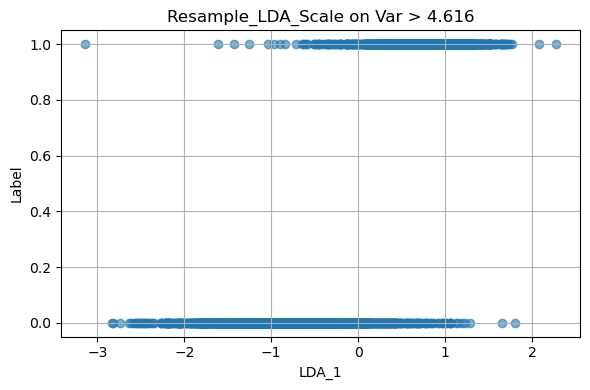

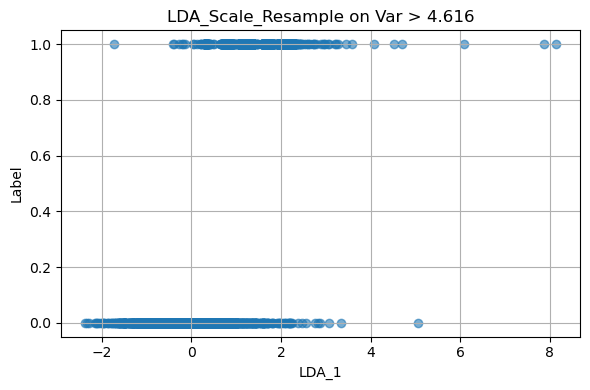

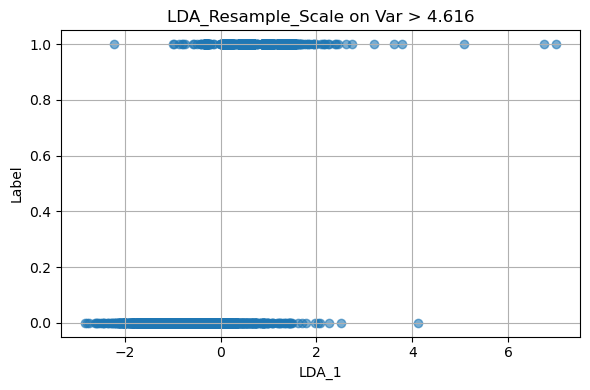

In [177]:
for df, df_name, sequence_str in results:
    # Only plot if LDA_1 exists (some sequences may not include apply_lda)
    if 'LDA_1' in df.columns:
        plt.figure(figsize=(6, 4))
        plt.scatter(df['LDA_1'], df['Label'], alpha=0.6)
        plt.title(f"{sequence_str} on {df_name}")
        plt.xlabel("LDA_1")
        plt.ylabel("Label")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

## Evaluate

In [181]:
# StratifiedKFold for consistency
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Collect results
evaluation_results = []

for df, df_name, sequence_str in results:
    if 'LDA_1' in df.columns:  # Only evaluate if LDA was applied
        X = df[['LDA_1']]
        y = df['Label']

        model = LogisticRegression(class_weight='balanced', solver='liblinear')

        # Cross-validated predictions
        y_pred = cross_val_predict(model, X, y, cv=cv)
        y_scores = cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:, 1]

        # Metrics
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        pr_auc = average_precision_score(y, y_scores)
        conf_matrix = confusion_matrix(y, y_pred)

        evaluation_results.append({
            'df_name': df_name,
            'sequence': sequence_str,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'pr_auc': pr_auc,
            'confusion_matrix': conf_matrix
        })

# Create summary DataFrame
eval_df = pd.DataFrame(evaluation_results)

# Optional: Display or save
display(eval_df)
# eval_df.to_csv("lda_logreg_evaluation_summary.csv", index=False)

,df_name,sequence,precision,recall,f1_score,pr_auc,confusion_matrix
0,Var > 0,Scale_Resample_LDA,0.970588,0.969925,0.970256,0.994643,"[[1420, 43], [44, 1419]]"
1,Var > 0,Scale_LDA_Resample,0.917456,0.926863,0.922135,0.950474,"[[1341, 122], [107, 1356]]"
2,Var > 0,Resample_Scale_LDA,0.973595,0.982912,0.978231,0.995288,"[[1424, 39], [25, 1438]]"
3,Var > 0,Resample_LDA_Scale,0.972936,0.982912,0.977899,0.995271,"[[1423, 40], [25, 1438]]"
4,Var > 0,LDA_Scale_Resample,0.916892,0.927546,0.922188,0.950488,"[[1340, 123], [106, 1357]]"
5,Var > 0,LDA_Resample_Scale,0.917966,0.925496,0.921715,0.950469,"[[1342, 121], [109, 1354]]"
6,Var > 0.05,Scale_Resample_LDA,0.922563,0.944634,0.933468,0.971949,"[[1347, 116], [81, 1382]]"
7,Var > 0.05,Scale_LDA_Resample,0.849901,0.882433,0.865862,0.895307,"[[1235, 228], [172, 1291]]"
8,Var > 0.05,Resample_Scale_LDA,0.927904,0.950103,0.938872,0.969427,"[[1355, 108], [73, 1390]]"
9,Var > 0.05,Resample_LDA_Scale,0.927952,0.950786,0.939230,0.969384,"[[1355, 108], [72, 1391]]"


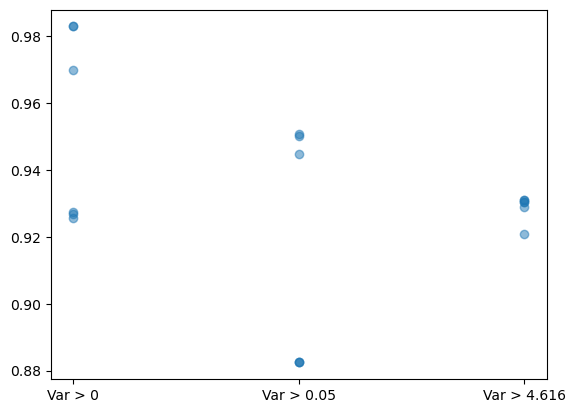

In [198]:
plt.figure()
plt.scatter(eval_df['df_name'],eval_df['recall'], alpha=.5)
plt.show()

### Plot confusion marices

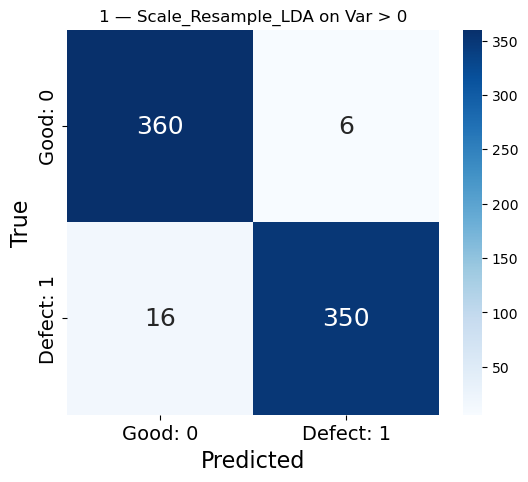

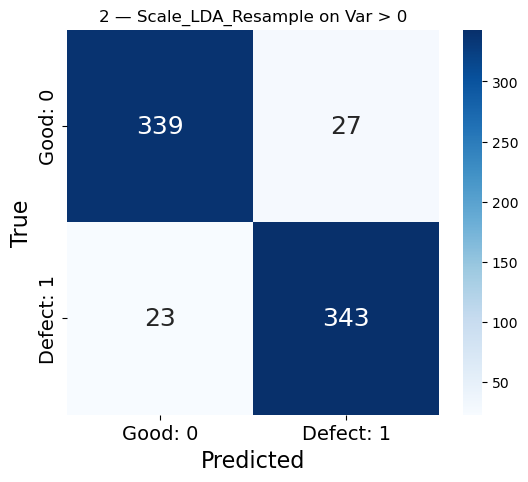

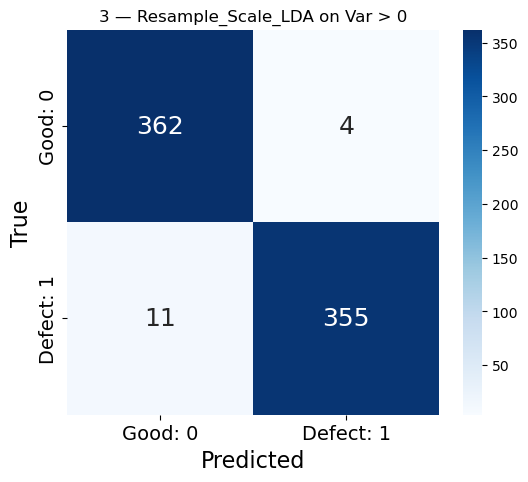

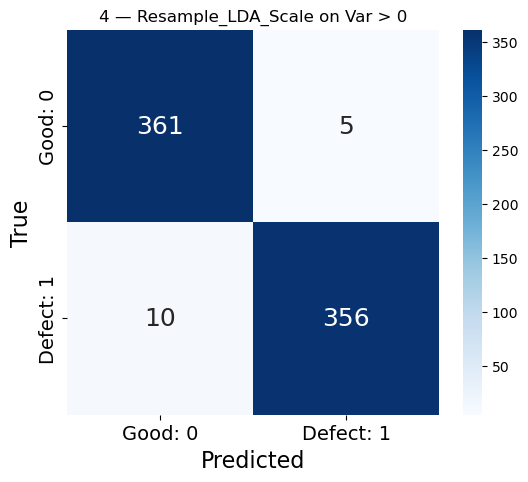

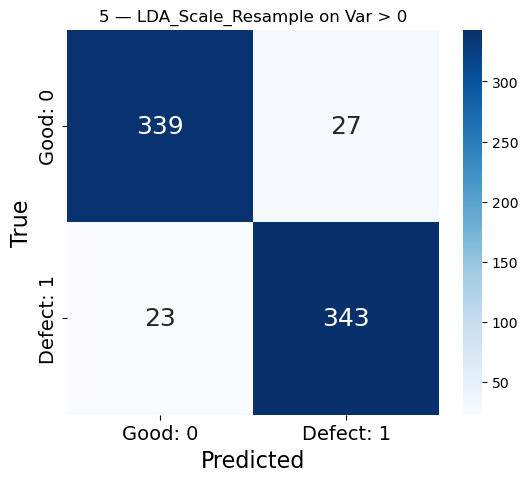

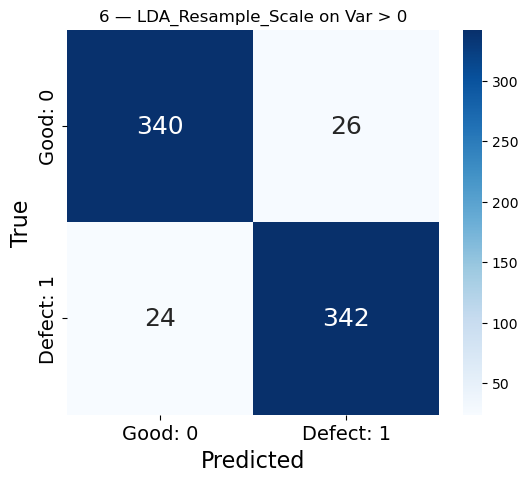

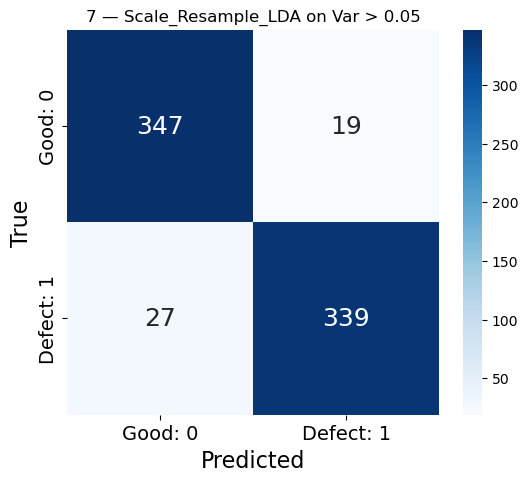

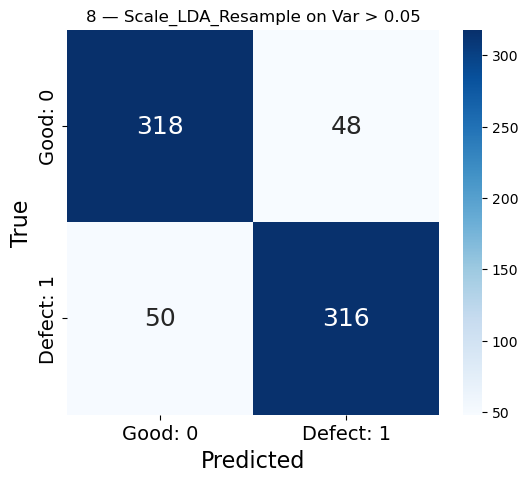

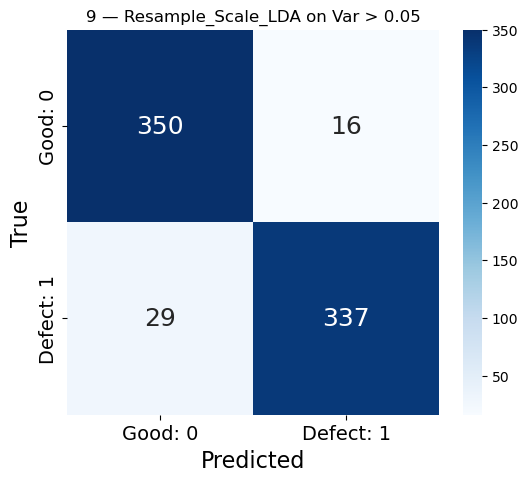

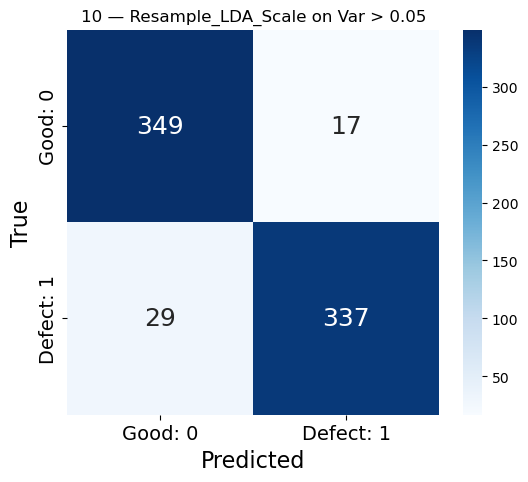

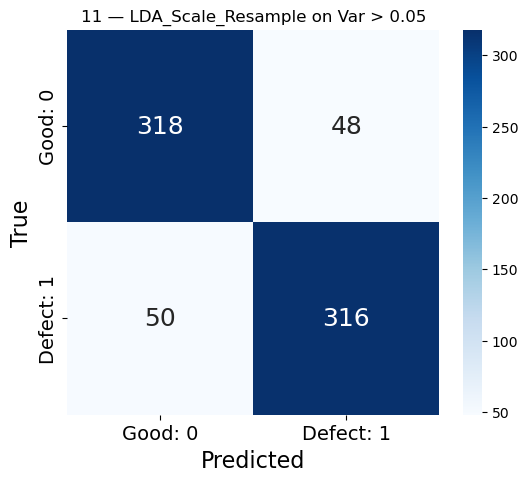

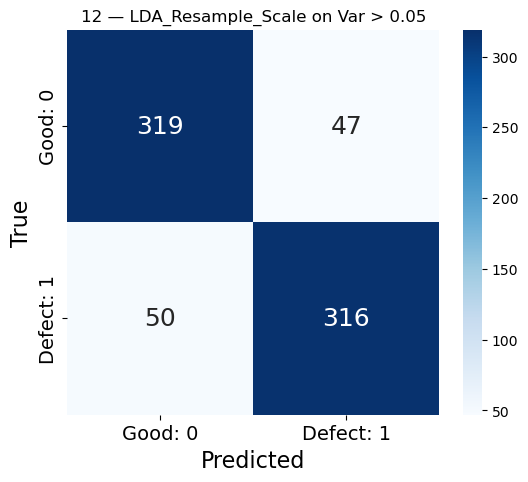

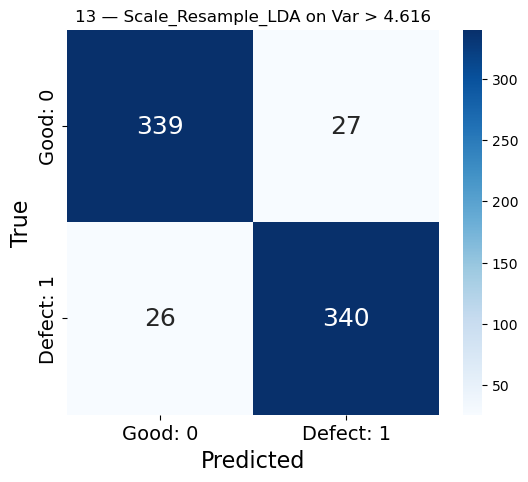

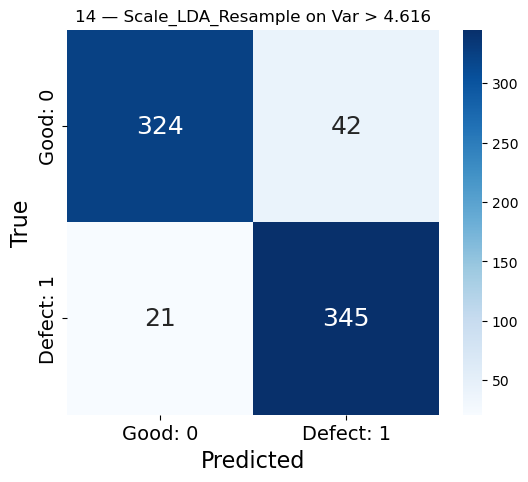

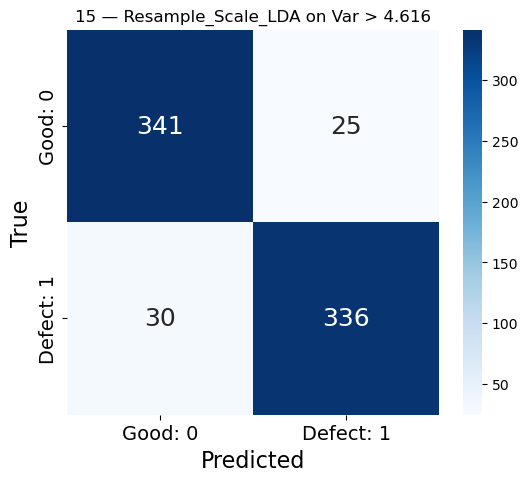

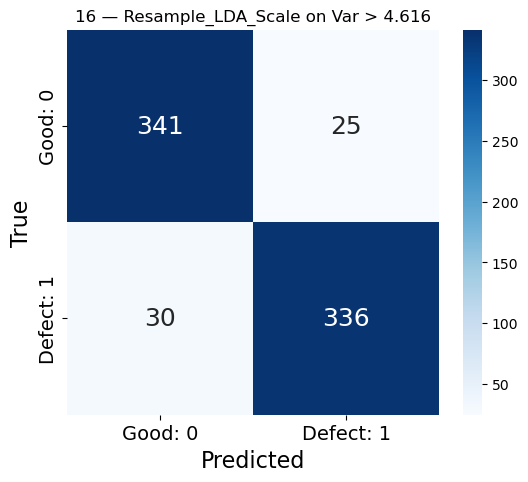

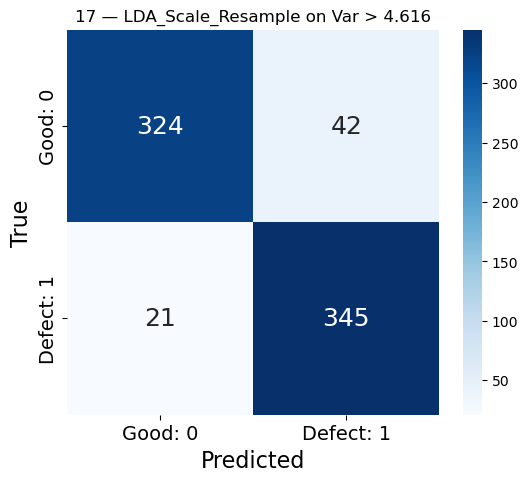

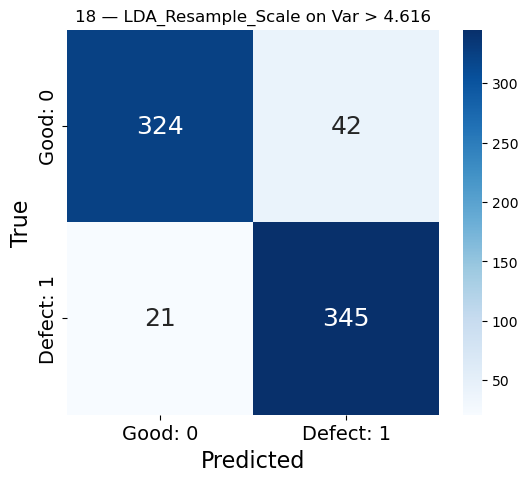

In [187]:
for i in range(len(results)):
    df, df_name, sequence_str = results[i]
    
    # Ensure LDA_1 and Label exist
    if 'LDA_1' in df.columns and 'Label' in df.columns:
        X = df[['LDA_1']]
        y = df['Label']
    
        # Split to simulate a real prediction
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    
        model = LogisticRegression(class_weight='balanced', solver='liblinear')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)

        fig, ax = plt.subplots(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                    xticklabels=labels, yticklabels=labels,
                    annot_kws={"size": 18})
        plt.title(f"{i+1} — {sequence_str} on {df_name}")
        plt.xlabel('Predicted', fontsize=16)
        plt.ylabel('True', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.show()

In [196]:
idx = eval_df['recall'].idxmax()
best_row = eval_df.loc[idx]
print(idx)
best_row

2


df_name                              Var > 0
sequence                  Resample_Scale_LDA
precision                           0.973595
recall                              0.982912
f1_score                            0.978231
pr_auc                              0.995288
confusion_matrix    [[1424, 39], [25, 1438]]
Name: 2, dtype: object

In [199]:
def get_best_result(eval_df, metric='f1_score', ascending=False):
    """
    Returns the row(s) with the best value for a given metric.

    Args:
        eval_df (pd.DataFrame): The evaluation results dataframe.
        metric (str): The column/metric to sort by.
        ascending (bool): Whether lower values are better (e.g., for loss).

    Returns:
        pd.DataFrame: Top-scoring row(s) based on the metric.
    """
    if metric not in eval_df.columns:
        raise ValueError(f"'{metric}' is not a column in the dataframe.")
    
    best_value = eval_df[metric].max() if not ascending else eval_df[metric].min()
    best_rows = eval_df[eval_df[metric] == best_value]

    return best_rows

In [202]:
best_recall = get_best_result(eval_df,metric='recall')
best_recall

,df_name,sequence,precision,recall,f1_score,pr_auc,confusion_matrix
2,Var > 0,Resample_Scale_LDA,0.973595,0.982912,0.978231,0.995288,"[[1424, 39], [25, 1438]]"
3,Var > 0,Resample_LDA_Scale,0.972936,0.982912,0.977899,0.995271,"[[1423, 40], [25, 1438]]"
